In [1]:
# Load imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
# Load the datasets
files = {
    'circuits': 'archive/circuits.csv',
    'constructor_results': 'archive/constructor_results.csv',
    'constructor_standings': 'archive/constructor_standings.csv',
    'constructors': 'archive/constructors.csv',
    'driver_standings': 'archive/driver_standings.csv',
    'drivers': 'archive/drivers.csv',
    'lap_times': 'archive/lap_times.csv',
    'pit_stops': 'archive/pit_stops.csv',
    'qualifying': 'archive/qualifying.csv',
    'races': 'archive/races.csv',
    'results': 'archive/results.csv',
    'seasons': 'archive/seasons.csv',
    'sprint_results': 'archive/sprint_results.csv',
    'status': 'archive/status.csv'
}

# Load all datasets into a dictionary
data = {name: pd.read_csv(path) for name, path in files.items()}

In [3]:
# Convert milliseconds to "minutes:seconds.milliseconds" format
def convert_to_time_format(ms):
    minutes = ms // 60000
    seconds = (ms % 60000) // 1000
    milliseconds = ms % 1000
    return f"{int(minutes)}:{int(seconds):02}.{int(milliseconds):03}"

In [4]:
# Convert lap times from "minutes:seconds" to milliseconds
def convert_lap_time_to_milliseconds(lap_time_str):
    if lap_time_str == r'\N':
        return np.nan  # Return NaN for missing values
    minutes, seconds = lap_time_str.split(':')
    return (int(minutes) * 60 * 1000) + (float(seconds) * 1000)

In [5]:
# Merge qualifying data with race information for 2024
races_subset = data['races'][['raceId', 'name', 'year']]
qualifying = pd.merge(data['qualifying'], races_subset, on='raceId')
qualifying_2024 = qualifying[qualifying['year'] == 2024]

In [6]:
# Filter for Bahrain Grand Prix
bahrain_quali = qualifying_2024[qualifying_2024['name'] == "Bahrain Grand Prix"]

In [7]:
# Merge with drivers
drivers_subset = data['drivers'][['driverId', 'code']]
bahrain_quali = pd.merge(bahrain_quali, drivers_subset, on='driverId')

In [8]:
# Convert lap times to milliseconds
bahrain_quali['q1_ms'] = bahrain_quali['q1'].apply(convert_lap_time_to_milliseconds)
bahrain_quali['q2_ms'] = bahrain_quali['q2'].apply(convert_lap_time_to_milliseconds)
bahrain_quali['q3_ms'] = bahrain_quali['q3'].apply(convert_lap_time_to_milliseconds)

In [9]:
# Calculate the fastest lap time for each driver
bahrain_quali['fastest_lap_ms'] = bahrain_quali[['q1_ms', 'q2_ms', 'q3_ms']].min(axis=1, skipna=True)
bahrain_quali['fastest_lap'] = bahrain_quali['fastest_lap_ms'].apply(convert_to_time_format)

In [10]:
# Merge with constructors data
constructors_subset = data['constructors'][['constructorId', 'name']].rename(columns={'name': 'team_name'})
bahrain_quali = pd.merge(bahrain_quali, constructors_subset, on='constructorId')

In [11]:
# Calculate time difference from fastest lap
bahrain_quali['time_difference_from_fastest'] = (bahrain_quali['fastest_lap_ms'] - bahrain_quali['fastest_lap_ms'].min()) / 6000
bahrain_quali = bahrain_quali.sort_values(by='time_difference_from_fastest')

In [12]:
# Define colors for constructors
constructor_colors = {
    'Ferrari': '#E8002D',
    'Sauber': '#52E252',
    'Red Bull': '#3671C6',
    'McLaren': '#FF8000',
    'Mercedes': '#27F4D2',
    'Williams': '#64C4FF',
    'Alpine F1 Team': '#FF87BC',
    'Aston Martin': '#229971',
    'RB F1 Team': '#6692FF',
    'Haas F1 Team': '#B6BABD',
}

bahrain_quali['color'] = bahrain_quali['team_name'].map(constructor_colors)

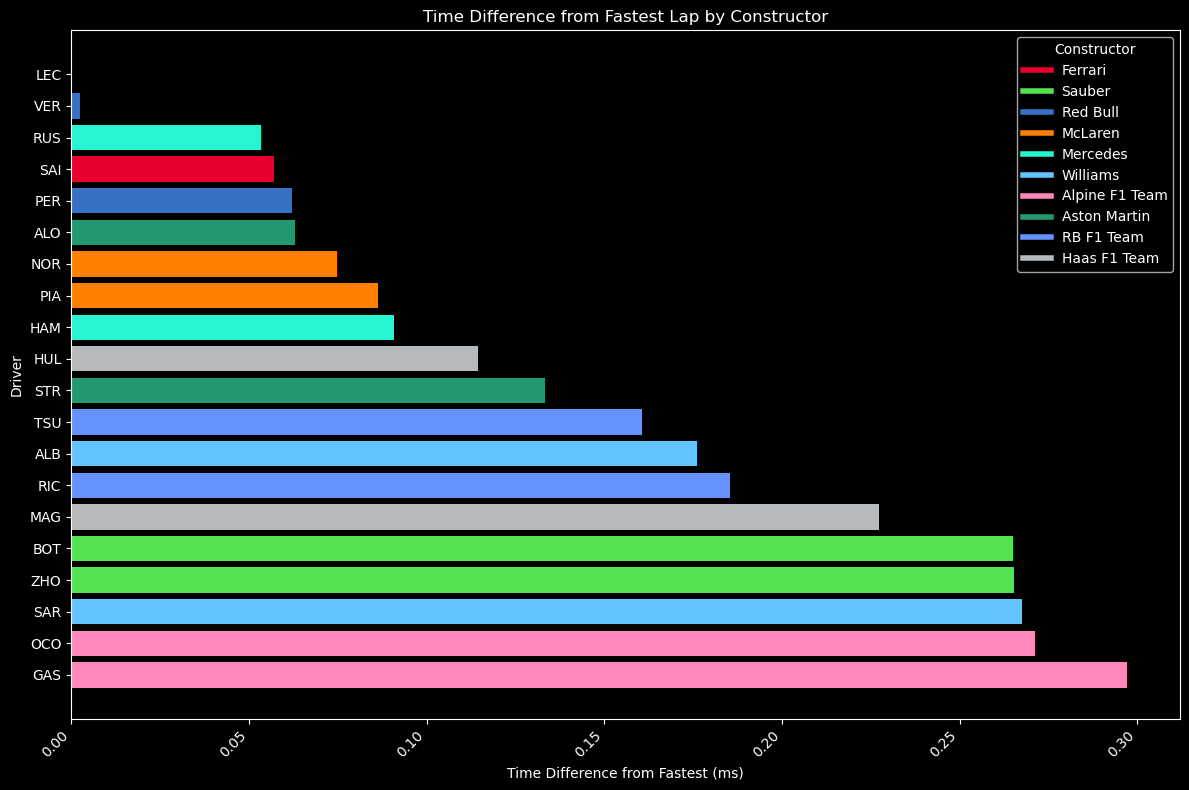

In [13]:
# Plot time difference from fastest lap
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
bars = plt.barh(bahrain_quali['code'], bahrain_quali['time_difference_from_fastest'], color=bahrain_quali['color'])

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in constructor_colors.values()]
labels = list(constructor_colors.keys())
plt.legend(handles, labels, title="Constructor")

# Add labels and title
plt.xlabel("Time Difference from Fastest (ms)")
plt.ylabel("Driver")
plt.xticks(rotation=45, ha='right')
plt.title("Time Difference from Fastest Lap by Constructor")
plt.gca().invert_yaxis()  # Invert y-axis to have the slowest drivers at the top
plt.tight_layout()
plt.show()

In [15]:
# Prepare lap times data for Bahrain Grand Prix
lap_times = pd.merge(data['lap_times'], races_subset[races_subset['year'] == 2024], on='raceId')
lap_times = pd.merge(lap_times, data['drivers'][['driverId', 'code', 'forename', 'surname']], on='driverId')
bahrain_gp = lap_times[lap_times['name'] == 'Bahrain Grand Prix'].copy()

In [16]:
# Convert lap times to minutes
bahrain_gp['lap_time_minutes'] = bahrain_gp['milliseconds'] / 60000

In [17]:
# Convert milliseconds to minutes:seconds.milliseconds format
def convert_to_time_format(ms):
    minutes = ms // 60000
    seconds = (ms % 60000) // 1000
    milliseconds = ms % 1000
    return f"{int(minutes)}:{int(seconds):02}.{int(milliseconds):03}"

In [18]:
# Function to format y-axis ticks for minutes and seconds
def format_minutes(x, pos):
    minutes = int(x)
    seconds = (x - minutes) * 60
    return f'{minutes:02}:{seconds:05.3f}'

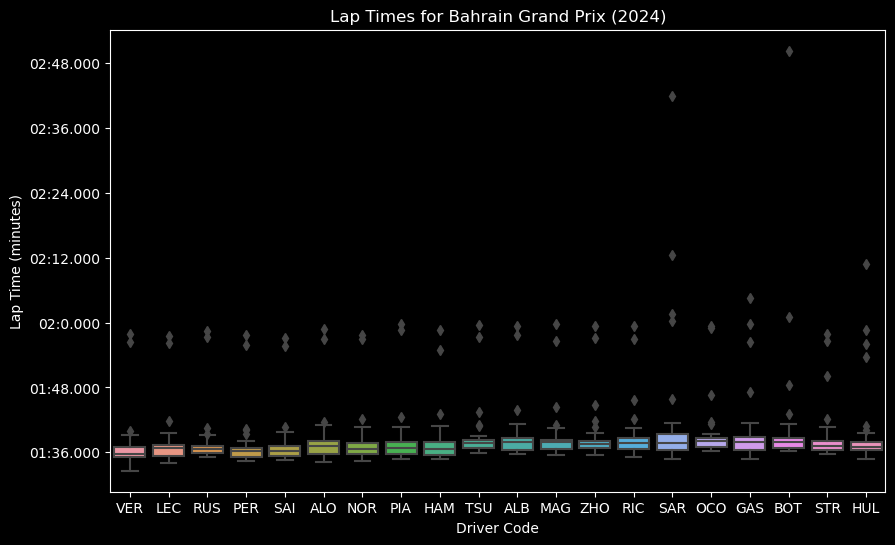

In [19]:
# Plot lap times boxplot for Bahrain Grand Prix
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.boxplot(x='code', y='lap_time_minutes', data=bahrain_gp)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_minutes))
plt.xlabel('Driver Code')
plt.ylabel('Lap Time (minutes)')
plt.title('Lap Times for Bahrain Grand Prix (2024)')
plt.show()

In [20]:
# Remove outliers from lap times
Q1 = bahrain_gp['lap_time_minutes'].quantile(0.25)
Q3 = bahrain_gp['lap_time_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_bahrain_gp = bahrain_gp[(bahrain_gp['lap_time_minutes'] >= lower_bound) & (bahrain_gp['lap_time_minutes'] <= upper_bound)]

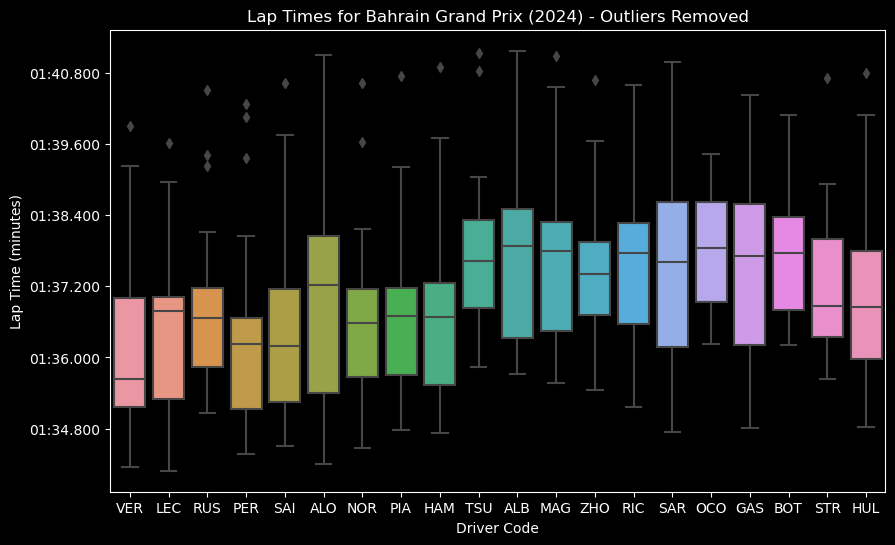

In [21]:
# Plot filtered lap times boxplot
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.boxplot(x='code', y='lap_time_minutes', data=filtered_bahrain_gp)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_minutes))
plt.xlabel('Driver Code')
plt.ylabel('Lap Time (minutes)')
plt.title('Lap Times for Bahrain Grand Prix (2024) - Outliers Removed')
plt.show()

In [22]:
# Calculate and print mean and standard deviation of lap times
bahrain_gp['lap_time_formatted'] = bahrain_gp['milliseconds'].apply(convert_to_time_format)
mean_lap_time_ms = bahrain_gp['milliseconds'].mean()
std_lap_time_ms = bahrain_gp['milliseconds'].std()
mean_lap_time = convert_to_time_format(mean_lap_time_ms)
std_lap_time = convert_to_time_format(std_lap_time_ms)
print(f"Mean Lap Time: {mean_lap_time}")
print(f"Standard Deviation of Lap Times: {std_lap_time}")

Mean Lap Time: 1:38.124
Standard Deviation of Lap Times: 0:05.333


In [23]:
# Calculate statistics for each driver
stats = bahrain_gp.groupby('driverId')['milliseconds'].agg(['mean', 'std'])
driver_names = lap_times[['driverId', 'forename', 'surname']].drop_duplicates().set_index('driverId')
stats = stats.join(driver_names, on='driverId')
stats['mean_time'] = stats['mean'].apply(convert_to_time_format)
stats['std_time'] = stats['std'].apply(convert_to_time_format)

In [24]:
# Display sorted statistics
stats_subset = stats[['forename', 'surname', 'mean_time', 'std_time']]
stats_subset.sort_values("std_time")

,forename,surname,mean_time,std_time
driverId,,,,
832,Carlos,Sainz,1:37.014,0:03.966
844,Charles,Leclerc,1:37.270,0:04.004
815,Sergio,Pérez,1:36.968,0:04.026
1,Lewis,Hamilton,1:37.457,0:04.049
846,Lando,Norris,1:37.424,0:04.076
847,George,Russell,1:37.395,0:04.096
855,Guanyu,Zhou,1:38.419,0:04.119
852,Yuki,Tsunoda,1:38.468,0:04.121
825,Kevin,Magnussen,1:38.447,0:04.122
